# Prepping the ADNI dataset
ADNI dataset can be found [here](https://www.kaggle.com/datasets/madhucharan/alzheimersdisease5classdatasetadni)

The dataset was downloaded from Kaggle with the images split into train and testing directories. The data consists of 4 disease state classes, which represent the disease progression, and a healthy congitive normal class. The images were originally downloaded from the [ADNI database](https://ida.loni.usc.edu/login.jsp?project=ADNI&page=HOME) and processed into a jpeg format to increase the speed of research. 

1296 images total

train data (1,101 images)
1. EMCI -> 204
2. LMCI -> 61
3. MCI -> 198
4. AD -> 145
5. CN -> 493 

test data (195 images)
1. EMCI -> 36
2. LMCI -> 11
3. MCI -> 35
4. AD -> 26
5. CN -> 87

In [61]:
import os
import cv2
import torch
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import torch.nn as nn 
from torchvision import models
from torchsummary import summary
import torch.optim as optim
import time


In [44]:
root_dir = '../'
data_dir = root_dir + 'data/ADNI/'
test_dir = data_dir + 'test/'
train_dir = data_dir + 'train/'

os.listdir(train_dir)



['AD', 'CN', 'LMCI', 'EMCI', 'MCI']

In [45]:
def count_files(dir):
    return len([1 for x in list(os.scandir(dir)) if x.is_file()])

classes = ['CN', 'AD', 'LMCI', 'EMCI', 'MCI']

print('Training data: ')
for c in classes:
    #dir = data_dir + c
    print('{}: {} images'.format(c, count_files(train_dir+c)))


Training data: 
CN: 493 images
AD: 145 images
LMCI: 61 images
EMCI: 204 images
MCI: 198 images


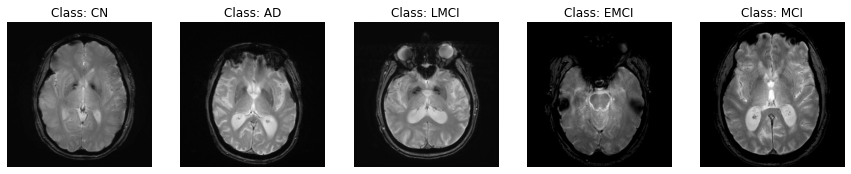

In [46]:
def load_images(dir, classes):
    imgs = []
    for c in classes:
        path = dir + str(c)
        temp = []
        for f in os.listdir(path):
            temp.append(os.path.join(path,f))
        imgs.append(temp)
    
    return dict(zip(classes, imgs))

img_dict = load_images(train_dir, classes)

plt.figure(figsize=(15,30))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(plt.imread(img_dict[classes[i]][0]), cmap='gray')
    plt.title("Class: {}".format(classes[i]))
    plt.axis("off")


### convert images to arrays 

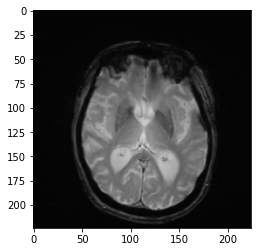

In [47]:
img_folder = '../data/ADNI/train/'
IMG_SIZE = 224

def create_dataset(img_folder):

    img_data_array=[]
    class_name=[]

    for dir in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir)):

            image_path = os.path.join(img_folder, dir, file)
            image= cv2.imread(image_path)
            image=cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            img_data_array.append(image)
            class_name.append(dir)

    return img_data_array, class_name


img_data, class_name = create_dataset(img_folder=img_folder)
plt.imshow(img_data[0])

for img in img_data:
    img = img.ToTensor

### convert labels to numeric codes

In [48]:
target_dict={k: v for v, k in enumerate (np.unique(class_name))}
target_dict

{'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3, 'MCI': 4}

convert class names to the respective numeric value based on the dictionary created above

In [49]:

target_val = [target_dict[class_name[i]] for i in range(len(class_name))]


In [56]:

alexnet = models.alexnet(pretrained=True)
#alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4,4), padding=(2,2))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Alexnet's default output size is 1,000, but we need it to match the number of classes we have (5)

In [57]:
# Freeze model params...
for param in alexnet.parameters():
    param.requires_grad = False

In [60]:
# change the final layer of the AlexNet model to match our class num for transfer learning
NUM_CLASS = 5
alexnet.classifier[6] = nn.Linear(4096,  NUM_CLASS)

# add softmax output layer
alexnet.classifier.add_module('7', nn.LogSoftmax(dim=1))
summary(alexnet, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          (23,296)
|    └─ReLU: 2-2                         [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         (307,392)
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         (663,936)
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         (884,992)
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         (590,080)
|    └─ReLU: 2-12                        [-1, 256, 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          (23,296)
|    └─ReLU: 2-2                         [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         (307,392)
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         (663,936)
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         (884,992)
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         (590,080)
|    └─ReLU: 2-12                        [-1, 256, 

In [ ]:
def train_model(model, epochs=25):
    '''
    function to train the model
    Parameters
        :param model: Model to train
        :param epochs: Number of epochs (default=25)
    Returns
        model: Trained model
        history: (dict object): Training loss and accuracy
    '''
    start = time.time()
    history = []
    best_acc = 0.0
    for epoch in range (epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # set model to training mode
        model.train()